<a href="https://colab.research.google.com/github/lcbjrrr/fiap-bdt-ml/blob/master/Kalman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext rpy2.ipython


/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [0]:
%%R
# SS Data Generation Function


SS = function(Model,T) {
  
  # Number of Observation T
  # Model with 4 matrices H(pxm), F(mxm), R(pxp) and Q(mxm)
  
  # Creating the Output Vectors and Matrices
  p = dim(Model$H)[1]
  print(p)
  m = dim(Model$F)[1]
  y = matrix(0,p,T)
  x = matrix(0,m,T+1)
  
  sqrtR = Model$R^0.5
  sqrtQ = Model$Q^0.5  

  set.seed(10)  
  for (t in 1:T) {
    rnorm_p = rnorm(p) 
    rnorm_m = rnorm(m)
    print('h')
    print(Model$H)
    print('xt')
    print(x[,t])
    print('r')
    print( sqrtR)
    print('p')
    print(rnorm_p)
    #print('I')
    #print((Model$H %*% x[,t]) )
    #print('II')
    #print((sqrtR %*% rnorm_p ))
    #print('I + II')
    #print((Model$H %*% x[,t]) + (sqrtR %*% rnorm_p ))

    print('f')
    print(Model$F)
    print('xt')
    print(x[,t])
    print('q')
    print(sqrtQ)
    print('m')
    print(rnorm_m )


    #print(Model$H %*% x[,t] + sqrtR %*% rnorm(p))
    #print(Model$F %*% x[,t] + sqrtQ %*% rnorm(m))

    y[,t] = (Model$H %*% x[,t]) + (sqrtR %*% rnorm_p )
    x[,t+1] = (Model$F %*% x[,t]) + (sqrtQ %*% rnorm_m )
    print('# Y')
    print(y)
    print('# X')
    print(x)
  } 
  return(y)
}



In [0]:
%%R
# Local Linear Trend Model

LLTM = list(H = matrix(c(1,0),1,2),
            R = matrix(1),
            F = matrix(c(1,0,1,1),2,2),
            Q = diag(c(0.5,0.001))
)

LLTM

$H
     [,1] [,2]
[1,]    1    0

$R
     [,1]
[1,]    1

$F
     [,1] [,2]
[1,]    1    1
[2,]    0    1

$Q
     [,1]  [,2]
[1,]  0.5 0.000
[2,]  0.0 0.001



[1] 1
[1] "h"
     [,1] [,2]
[1,]    1    0
[1] "xt"
[1] 0 0
[1] "r"
     [,1]
[1,]    1
[1] "p"
[1] 0.01874617
[1] "f"
     [,1] [,2]
[1,]    1    1
[2,]    0    1
[1] "xt"
[1] 0 0
[1] "q"
          [,1]       [,2]
[1,] 0.7071068 0.00000000
[2,] 0.0000000 0.03162278
[1] "m"
[1] -0.1842525 -1.3713305
[1] "# Y"
           [,1] [,2] [,3] [,4]
[1,] 0.01874617    0    0    0
[1] "# X"
     [,1]        [,2] [,3] [,4] [,5]
[1,]    0 -0.13028622    0    0    0
[2,]    0 -0.04336528    0    0    0
[1] "h"
     [,1] [,2]
[1,]    1    0
[1] "xt"
[1] -0.13028622 -0.04336528
[1] "r"
     [,1]
[1,]    1
[1] "p"
[1] -0.5991677
[1] "f"
     [,1] [,2]
[1,]    1    1
[2,]    0    1
[1] "xt"
[1] -0.13028622 -0.04336528
[1] "q"
          [,1]       [,2]
[1,] 0.7071068 0.00000000
[2,] 0.0000000 0.03162278
[1] "m"
[1] 0.2945451 0.3897943
[1] "# Y"
           [,1]       [,2] [,3] [,4]
[1,] 0.01874617 -0.7294539    0    0
[1] "# X"
     [,1]        [,2]        [,3] [,4] [,5]
[1,]    0 -0.13028622  0.03462335

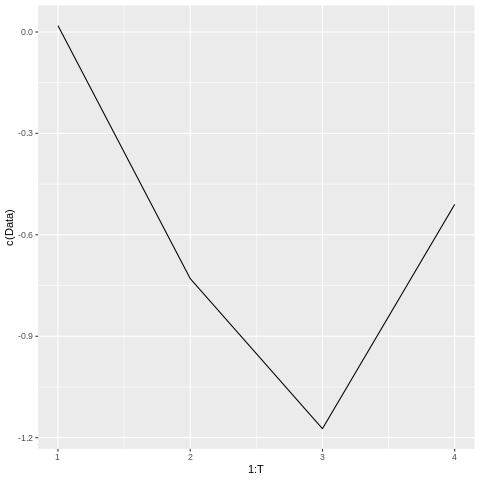

In [0]:
%%R
T = 4
Data = SS(LLTM,T)

# Plotting
library(ggplot2)
library(repr)
options(repr.plot.width=5, repr.plot.height=4)
 
qplot(1:T,c(Data),geom = "line")

In [0]:
%%R
# Kalman Filter Implementaion

KF = function(Data, Model) {
  
  # Data as matrix (pxT)
  # Model has 4 matrices H(pxm), F(mxm), R(pxp) and Q(mxm)
  
  # Creating the Output Vectors and Matrices
  p = dim(Data)[1]
  T = dim(Data)[2]
  m = dim(Model$F)[1]
  v = y_hat = matrix(0,p,T) # estimation error
  a = matrix(0,m,T)         # estimate for states
  a_minus = matrix(0,m,T+1) 
  S = array(0,dim = c(p,p,T))
  V = array(0,dim = c(m,m,T))
  V_minus = array(0,dim = c(m,m,T+1))
  K = array(0,dim = c(m,p,T))  
  
  for (t in 1:T) {
    i=!is.na(Data[,t])                  # Find the non-missing  
    y_hat[,t] = Model$H %*% a_minus[,t] # Filtered Values
    H = Model$H[i,,drop = FALSE]
    R = Model$R[i,i,drop=FALSE]  
    
    # Update Equations
    v[i,t] = Data[i,t] - H %*% a_minus[,t,drop = FALSE]
    S[i,i,t] = H %*% V_minus[,,t] %*% t(H) + R # estimation error + measurement error
    
    # below the kalman gain
    # kalman gain = Eest / (Eest + Emed)
    print('S')
    print(S[i,i,t])
    if (any(i)) K[,i,t] = V_minus[,,t] %*% t(H) %*% solve(S[i,i,t]) 
    a[,t] = a_minus[,t] + K[,i,t] %*% v[i,t,drop=FALSE]
    print('K[,i,t]')
    print(K[,i,t])
    print('H')
    print(H)
    print('@')
    print(K[,i,t] %*% H)
    V[,,t] = (diag(m) - K[,i,t] %*% H) %*% V_minus[,,t]
    
    # Forecast Equations
    a_minus[,t+1] = Model$F %*% a[,t]
    V_minus[,,t+1] = Model$F %*% V[,,t] %*%  t(Model$F) + Model$Q
  }
  
  return(list(v=v,S=S,K=K,a=a,a_minus=a_minus[,-(T+1)],V=V,V_minus=V_minus[,,-(T+1)],y_hat=y_hat))  
}


[1] "S"
[1] 1
[1] "K[,i,t]"
[1] 0 0
[1] "H"
     [,1] [,2]
[1,]    1    0
[1] "@"
     [,1] [,2]
[1,]    0    0
[2,]    0    0
[1] "S"
[1] 1.5
[1] "K[,i,t]"
[1] 0.3333333 0.0000000
[1] "H"
     [,1] [,2]
[1,]    1    0
[1] "@"
          [,1] [,2]
[1,] 0.3333333    0
[2,] 0.0000000    0
[1] "S"
[1] 1.834333
[1] "K[,i,t]"
[1] 0.4548428130 0.0005451572
[1] "H"
     [,1] [,2]
[1,]    1    0
[1] "@"
             [,1] [,2]
[1,] 0.4548428130    0
[2,] 0.0005451572    0
[1] "S"
[1] 1.957933
[1] "K[,i,t]"
[1] 0.489257184 0.001299642
[1] "H"
     [,1] [,2]
[1,]    1    0
[1] "@"
            [,1] [,2]
[1,] 0.489257184    0
[2,] 0.001299642    0


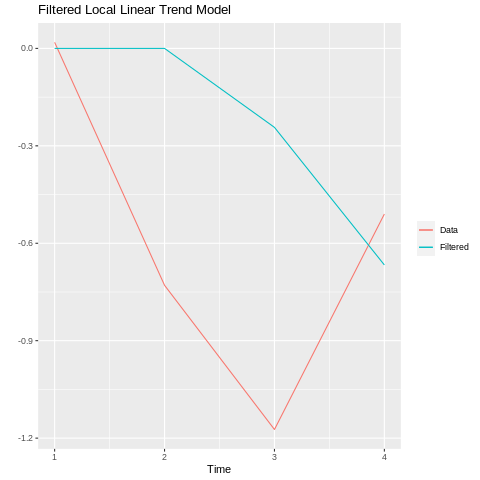

In [0]:
%%R



# Applying the KF in the LLTM

Out = KF(Data,LLTM)

options(repr.plot.width=6.5, repr.plot.height=4)

plot_data = data.frame(time = 1:T,
                       true = c(Data),
                       filtered = c(Out$y_hat),
                       sd = sqrt(c(Out$S)))

nsd = 2

ggplot(plot_data, aes(x = time)) + 
  geom_line(aes(y = true, colour = "Data")) +
  geom_line(aes(y = filtered, colour = "Filtered")) +
  # geom_line(aes(y = filtered + nsd*sd, colour = "UB")) +
  # geom_line(aes(y = filtered - nsd*sd, colour = "LB")) +
  # theme(legend.position = c(0.8, 0.8)) +
  theme(legend.title=element_blank()) +
  ggtitle("Filtered Local Linear Trend Model") +
  xlab("Time") +
  ylab("")
